In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from windrose import WindroseAxes
from geopy.geocoders import Nominatim

pd.set_option('display.max_columns', 100)

</br>
</br>
</br>

## Importing and Overview
https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [2]:
df_IMP = pd.read_csv('./weatherAUS.csv')

In [3]:
df_IMP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
df_IMP.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


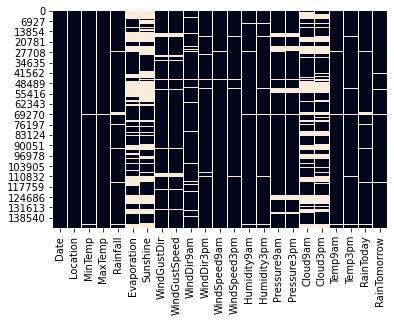

In [5]:
sns.heatmap(df_IMP.isna(), cbar=False);

</br>
</br>
</br>

## Cleaning and Feature Engineering

In [6]:
DF = (
    df_IMP
    .rename({'MinTemp': 'TempMin',
             'MaxTemp': 'TempMax'}, axis=1)
    # removing missing targets
    .query('RainTomorrow==RainTomorrow')
    # removing sparse features
    .drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RainToday'], axis=1)
    .sort_values(['Location', 'Date'])
    .reset_index(drop=True)
    .copy(deep=True)
)

# mapping directions
directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
mapping = {k: v*22.5 for v, k in enumerate(directions)}

# getting degrees
DF['WindGustDir'] = DF['WindGustDir'].map(mapping)
DF['WindDir9am'] = DF['WindDir9am'].map(mapping)
DF['WindDir3pm'] = DF['WindDir3pm'].map(mapping)

# calculating sin
DF['WindGustDir_sin'] = np.sin(np.deg2rad(DF['WindGustDir']))
DF['WindDir9am_sin'] = np.sin(np.deg2rad(DF['WindDir9am']))
DF['WindDir3pm_sin'] = np.sin(np.deg2rad(DF['WindDir3pm']))

# calculating cos
DF['WindGustDir_cos'] = np.cos(np.deg2rad(DF['WindGustDir']))
DF['WindDir9am_cos'] = np.cos(np.deg2rad(DF['WindDir9am']))
DF['WindDir3pm_cos'] = np.cos(np.deg2rad(DF['WindDir3pm']))

# mapping months
DF['Month'] = [datetime.strptime(x, '%Y-%m-%d').month for x in DF['Date']]
DF['Month_sin'] = np.sin(np.deg2rad(DF['Month']*30))
DF['Month_cos'] = np.cos(np.deg2rad(DF['Month']*30))

# mapping targets
DF['RainTomorrow'] = DF['RainTomorrow'].map({'Yes': 1, 'No': 0})

# flagging incomplete rows
DF['incomplete_row'] = DF.isnull().any(axis=1).astype(int)

In [7]:
# Getting coordinates
user_agent = '' # your API key goes here [https://developer.mapquest.com/]

try:
    coordinates = pd.read_csv('./coordinates.csv')
except:
    coordinates = pd.DataFrame({'Location': DF['Location'].unique(), 'lon': 0., 'lat': 0.})
    geolocator = Nominatim(user_agent=user_agent)
    for i in range(len(coordinates)):
        space_cake = re.sub("([a-z])([A-Z])","\g<1> \g<2>", coordinates['Location'][i])
        location = geolocator.geocode(space_cake + ', Australia')
        coordinates.loc[i, 'lon'] = location.longitude
        coordinates.loc[i, 'lat'] = location.latitude

    coordinates.to_csv('./coordinates.csv', index=False)

DF = DF.merge(coordinates, on='Location')
DF.to_csv('./weatherAUS_clean.csv', index=False)
DF.head()

,Date,Location,TempMin,TempMax,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainTomorrow,WindGustDir_sin,WindDir9am_sin,WindDir3pm_sin,WindGustDir_cos,WindDir9am_cos,WindDir3pm_cos,Month,Month_sin,Month_cos,incomplete_row,lon,lat
0,2008-07-01,Adelaide,8.8,15.7,5.0,315.0,48.0,225.0,270.0,13.0,15.0,92.0,67.0,1017.4,1017.7,13.5,14.9,0,-0.707107,-0.707107,-1.000000,7.071068e-01,-0.707107,-1.836970e-16,7,-0.5,-0.866025,0,138.599931,-34.92818
1,2008-07-02,Adelaide,12.7,15.8,0.8,225.0,35.0,202.5,225.0,13.0,15.0,75.0,52.0,1022.4,1022.6,13.7,15.5,0,-0.707107,-0.382683,-0.707107,-7.071068e-01,-0.923880,-7.071068e-01,7,-0.5,-0.866025,0,138.599931,-34.92818
2,2008-07-03,Adelaide,6.2,15.1,0.0,270.0,20.0,22.5,225.0,2.0,11.0,81.0,56.0,1027.8,1026.5,9.3,13.9,0,-1.000000,0.382683,-0.707107,-1.836970e-16,0.923880,-7.071068e-01,7,-0.5,-0.866025,0,138.599931,-34.92818
3,2008-07-04,Adelaide,5.3,15.9,0.0,22.5,30.0,22.5,45.0,6.0,13.0,71.0,46.0,1028.7,1025.6,10.2,15.3,0,0.382683,0.382683,0.707107,9.238795e-01,0.923880,7.071068e-01,7,-0.5,-0.866025,0,138.599931,-34.92818
4,2008-07-06,Adelaide,11.3,15.7,NaN,337.5,52.0,22.5,337.5,15.0,22.0,62.0,62.0,1019.5,1016.2,13.0,14.4,1,-0.382683,0.382683,-0.382683,9.238795e-01,0.923880,9.238795e-01,7,-0.5,-0.866025,1,138.599931,-34.92818


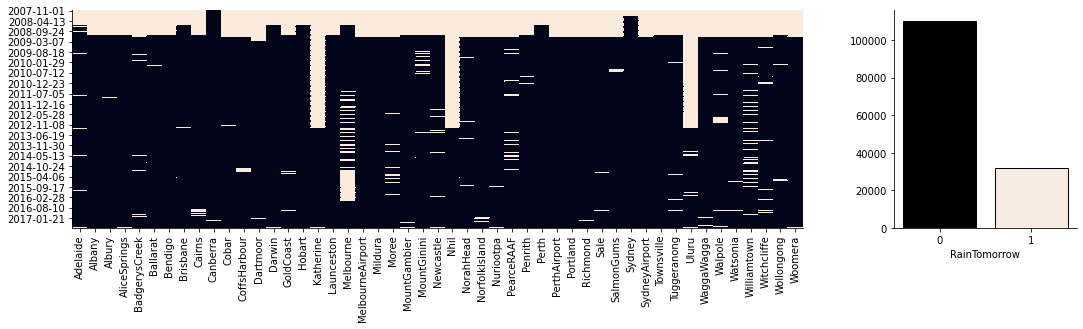

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4), gridspec_kw={'width_ratios': [4, 1]})

ts_nans = DF[['Date', 'Location', 'RainTomorrow']].pivot(index='Date', columns='Location').isna()
ts_nans.columns = ts_nans.columns.droplevel()
ts_nans.columns.name = None
ts_nans.index.name = None

classes = DF.groupby('RainTomorrow')['RainTomorrow'].count()

sns.heatmap(ts_nans, cbar=False, ax=ax[0])
sns.barplot(x=classes.index, y=classes.values, palette=['k', '#FAEBDD'], linewidth=1, edgecolor='k', ax=ax[1])
sns.despine()

</br>
</br>
</br>

## Train-Test split, Imputation and Scaling

In [23]:
DF = pd.read_csv('./weatherAUS_clean.csv')

In [24]:
# Train-Test split
cutoff = '2015-01-01'
drop_cols = ['Date', 'Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainTomorrow', 'incomplete_row']
ids_train = DF[DF['Date']<cutoff][['Date', 'Location']].reset_index(drop=True)
ids_test = DF[DF['Date']>=cutoff][['Date', 'Location']].reset_index(drop=True)
X_train = DF[DF['Date']<cutoff].drop(drop_cols, axis=1).reset_index(drop=True)
X_test = DF[DF['Date']>=cutoff].drop(drop_cols, axis=1).reset_index(drop=True)
y_train = DF[DF['Date']<cutoff]['RainTomorrow'].reset_index(drop=True)
y_test = DF[DF['Date']>=cutoff]['RainTomorrow'].reset_index(drop=True)
X_cols = X_train.columns

In [25]:
# Imputing missing values
n_neighbors = len(DF['Location'].unique())
imputer = KNNImputer(n_neighbors=n_neighbors).fit(X_train)

In [26]:
%%time
# Takes approx 5min on my shit machine
X_train = imputer.transform(X_train)

CPU times: user 4min 43s, sys: 52.4 s, total: 5min 35s
Wall time: 4min 49s


In [27]:
%%time
# Takes approx 2min
X_test = imputer.transform(X_test)

CPU times: user 2min 10s, sys: 20.7 s, total: 2min 30s
Wall time: 2min 9s


In [28]:
# Scaling core features

# Converting back to DataFrames briefly
X_train = pd.DataFrame(X_train, columns=X_cols)
X_test = pd.DataFrame(X_test, columns=X_cols)

# Selecting relevant colums
leave_out_cols = ['WindGustDir_sin', 'WindDir9am_sin', 'WindDir3pm_sin', 'WindGustDir_cos', 'WindDir9am_cos', 'WindDir3pm_cos', 'Month_sin', 'Month_cos', 'lon', 'lat']
X_train_core = X_train.drop(leave_out_cols, axis=1)
X_test_core = X_test.drop(leave_out_cols, axis=1)

# Fitting the scalar on the core data
scalar = MinMaxScaler().fit(X_train_core)
X_train_core = scalar.transform(X_train_core)
X_test_core = scalar.transform(X_test_core)

# Appending the left out columns
X_train = np.append(X_train_core, X_train[leave_out_cols], axis=1)
X_test = np.append(X_test_core, X_test[leave_out_cols], axis=1)

# Once more, back to DataFrames
X_train = pd.DataFrame(X_train, columns=X_cols)
X_test = pd.DataFrame(X_test, columns=X_cols)

In [29]:
# Scaling coordinates
# 1) centering around center of Australia
# 2) dividing by max value - squishing to [-1, 1]
LON = 133.7751
LAT = -25.2744
max_train_lon = X_train['lat'].abs().max()
max_train_lat = X_train['lon'].abs().max()

X_train['lon'] = (X_train['lon'] - LON) / max_train_lat
X_train['lat'] = (X_train['lat'] - LAT) / max_train_lon
X_test['lon'] = (X_test['lon'] - LON) / max_train_lat
X_test['lat'] = (X_test['lat'] - LAT) / max_train_lon

In [30]:
# Adding back ids
X_train = pd.concat([ids_train, X_train], axis=1)
X_test = pd.concat([ids_test, X_test], axis=1)

In [32]:
# Storing files in disk
X_train.to_csv('./X_train.csv', index=False)
X_test.to_csv('./X_test.csv', index=False)
y_train.to_csv('./y_train.csv', index=False)
y_test.to_csv('./y_test.csv', index=False)